In [1]:
# Importación de las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# Cargamos los datos de entrenamiento y el maestro de productos
data = pd.read_csv('train.csv', delimiter='|')
product_data = pd.read_csv('RentabilidadProduct.csv', delimiter='|')

# Vemos las primeras filas de cada conjunto de datos para tener una idea de los datos
print(data.head())

  fecha_compra  customer_id  product_id type_id  business_id channel_id   
0   2022-01-31         7157         510      BO           21          V  \
1   2022-01-31         7157         512      BO           21          V   
2   2022-01-31         9382         510      BO           21          V   
3   2022-01-31         9382         512      BO           21          V   
4   2022-01-31         9382         525      BO           21          V   

   cantidad_venta  monto_venta_transf  peso_venta_transf  
0             1.0            0.153431           0.005211  
1             1.0            0.153431           0.005211  
2             1.0            0.153431           0.005211  
3             1.0            0.153431           0.005211  
4             1.0            0.153431           0.005790  


In [3]:
print(product_data.head())

   product_id  family_id  negocio_id  category_id  tier_id   
0         881       1291          20          131        4  \
1         805       1224          20          131        3   
2         892       1089          20          146        1   
3         841       1224          20          131        3   
4         830       1089          20          131        1   

   utilidad_bruta_transf  
0              10.378017  
1              10.177925  
2              10.008243  
3               7.698362  
4               7.353678  


In [4]:
# We print some information about Google_stock
print('Google_stock is of type:', type(data))
print('Google_stock has shape:', data.shape)

Google_stock is of type: <class 'pandas.core.frame.DataFrame'>
Google_stock has shape: (2167848, 9)


## Data Cleaning

In [5]:
# Realizamos una exploración inicial de los datos
data.info()
data.describe(include='all')
data.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167848 entries, 0 to 2167847
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   fecha_compra        object 
 1   customer_id         int64  
 2   product_id          int64  
 3   type_id             object 
 4   business_id         int64  
 5   channel_id          object 
 6   cantidad_venta      float64
 7   monto_venta_transf  float64
 8   peso_venta_transf   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 148.9+ MB


fecha_compra          False
customer_id           False
product_id            False
type_id               False
business_id           False
channel_id            False
cantidad_venta        False
monto_venta_transf    False
peso_venta_transf     False
dtype: bool

In [5]:
# We count the number of NaN values in store_items
x =  data.isnull().sum().sum()
x2 = product_data.isnull().sum().sum()
# We print x
print('Number of NaN values in our DataFrame:', x)
print('Number of NaN values in our DataFrame:', x2)

Number of NaN values in our DataFrame: 0
Number of NaN values in our DataFrame: 0


In [10]:
# Buscamos los valores faltantes
data.isnull().sum()

fecha_compra          0
customer_id           0
product_id            0
type_id               0
business_id           0
channel_id            0
cantidad_venta        0
monto_venta_transf    0
peso_venta_transf     0
dtype: int64

In [11]:
# Comprobar duplicados
data.duplicated().sum()

0

**No hay valores faltantes ni duplicados**
Ahora realizamos el mismo análisis a product_data

In [12]:
product_data.info()
product_data.describe(include='all')
print("\nTipos de datos:\n", product_data.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             937 non-null    int64  
 1   family_id              937 non-null    int64  
 2   negocio_id             937 non-null    int64  
 3   category_id            937 non-null    int64  
 4   tier_id                937 non-null    int64  
 5   utilidad_bruta_transf  937 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 44.1 KB

Tipos de datos:
 product_id                 int64
family_id                  int64
negocio_id                 int64
category_id                int64
tier_id                    int64
utilidad_bruta_transf    float64
dtype: object


In [13]:
# Verificamos si hay algún valor nulo en 'cantidad_venta'
print("Valores nulos en 'cantidad_venta':", data['cantidad_venta'].isnull().sum())

# Convertimos 'customer_id' y 'product_id' a tipo categórico
data['customer_id'] = data['customer_id'].astype('category')
data['product_id'] = data['product_id'].astype('category')

# Verificamos los tipos de datos
print("\nTipos de datos:\n", data.dtypes)

Valores nulos en 'cantidad_venta': 0

Tipos de datos:
 fecha_compra            object
customer_id           category
product_id            category
type_id                 object
business_id              int64
channel_id              object
cantidad_venta         float64
monto_venta_transf     float64
peso_venta_transf      float64
dtype: object


In [17]:
# Creando la matriz de usuario-producto
user_product_matrix = data.pivot_table(index='customer_id', columns='product_id', values='cantidad_venta', fill_value=0)

# Visualizamos las primeras filas de la matriz
user_product_matrix.head()

product_id,1,2,3,4,5,6,7,8,9,10,...,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048
customer_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0,0.0,0,1.0,0.0,0,...,0.0,0,0,0,0,0,1.0,1.25,0.0,0.0
2,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,...,0.0,0,0,0,0,0,0.0,0.00,0.0,0.0
3,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,...,0.0,0,0,0,0,0,0.0,0.00,0.0,0.0
4,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,...,0.0,0,0,0,0,0,0.0,0.00,0.0,0.0
5,0.0,0.0,0.0,0.0,0,0.0,0,5.0,0.0,0,...,0.0,0,0,0,0,0,0.0,0.00,0.0,0.0


## Principal Component Analysis

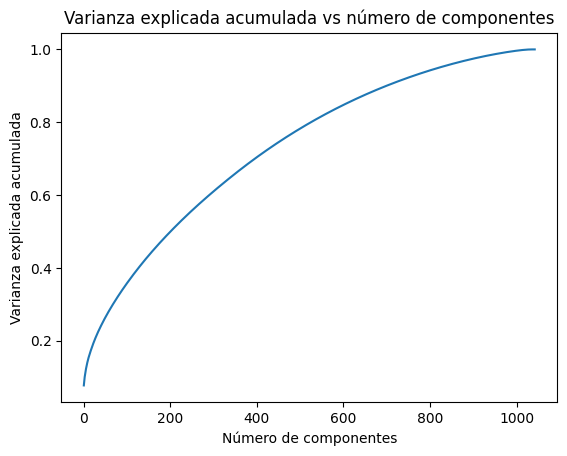

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Normalizamos los datos antes de aplicar PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_product_matrix)

# Ajustamos el modelo PCA a los datos
pca = PCA().fit(scaled_data)

# Graficamos la varianza explicada acumulada
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada vs número de componentes')
plt.show()


In [19]:
# Aplicamos PCA con 200 componentes
pca = PCA(n_components=200)
pca_data = pca.fit_transform(scaled_data)

# Convertimos los datos transformados a un DataFrame para facilitar su manejo
pca_df = pd.DataFrame(pca_data, index=user_product_matrix.index)

# Calculamos la matriz de similitud del coseno con los datos transformados
user_similarity_matrix_pca = cosine_similarity(pca_df)

# Convertimos la matriz de similitud a un DataFrame para facilitar su manejo
user_similarity_df_pca = pd.DataFrame(user_similarity_matrix_pca, index=user_product_matrix.index, columns=user_product_matrix.index)

# Visualizamos las primeras filas de la matriz de similitud
user_similarity_df_pca.head()


customer_id,1,2,3,4,5,6,7,8,9,10,...,15303,15304,15305,15306,15307,15308,15309,15310,15311,15312
customer_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.127048,0.289440,0.157450,0.476800,0.154055,0.409667,0.375892,0.299239,0.340752,...,-0.501690,-0.041484,-0.517721,-0.522574,-0.535081,-0.541306,-0.531439,-0.490854,-0.533368,-0.520437
2,0.127048,1.000000,0.186733,-0.044785,0.028339,0.017108,0.154838,0.076333,0.028276,0.152396,...,-0.051530,-0.002928,-0.118376,-0.094043,-0.075302,-0.076458,-0.069455,-0.093352,-0.080651,-0.092359
3,0.289440,0.186733,1.000000,0.303986,0.234694,0.343128,0.465621,0.315842,0.223942,0.533160,...,-0.293860,-0.046469,-0.397573,-0.375901,-0.357238,-0.360576,-0.345667,-0.371536,-0.372106,-0.380651
4,0.157450,-0.044785,0.303986,1.000000,-0.012746,0.338540,0.273145,0.289133,0.127294,0.446393,...,-0.038686,-0.061535,-0.153167,-0.053927,-0.079878,-0.083552,-0.080402,-0.120889,-0.099486,-0.109886
5,0.476800,0.028339,0.234694,-0.012746,1.000000,0.080056,0.401151,0.307176,0.315204,0.170387,...,-0.522416,-0.058535,-0.527394,-0.528932,-0.555888,-0.557469,-0.557028,-0.515214,-0.561567,-0.546562


In [20]:
def recommend_products(customer_id, n):
    # Obtenemos los clientes más similares al cliente dado
    similar_customers = user_similarity_df_pca[customer_id].sort_values(ascending=False)
    
    # Obtenemos los productos que el cliente dado ya ha comprado
    purchased_products = set(user_product_matrix.loc[customer_id].iloc[
        user_product_matrix.loc[customer_id].to_numpy().nonzero()[0]].index)
    
    # Inicializamos una lista para almacenar las recomendaciones
    recommendations = []
    
    # Recorremos los clientes más similares
    for similar_customer in similar_customers.index:
        # Obtenemos los productos que el cliente similar ha comprado
        similar_customer_products = set(user_product_matrix.loc[similar_customer].iloc[
            user_product_matrix.loc[similar_customer].to_numpy().nonzero()[0]].index)
        
        # Obtenemos los productos que el cliente similar ha comprado pero que el cliente dado no ha comprado aún
        new_products = similar_customer_products - purchased_products
        
        # Añadimos los nuevos productos a las recomendaciones
        recommendations += list(new_products)
        
        # Si ya tenemos suficientes recomendaciones, salimos del bucle
        if len(recommendations) >= n:
            break
    
    # Devolvemos las n primeras recomendaciones
    return recommendations[:n]

# Probamos la función con un cliente y un número de recomendaciones
recommend_products(1, 50)

[128,
 258,
 131,
 4,
 775,
 777,
 140,
 785,
 531,
 667,
 284,
 29,
 291,
 422,
 296,
 424,
 433,
 434,
 183,
 184,
 439,
 441,
 954,
 443,
 61,
 578,
 457,
 330,
 590,
 591,
 464,
 595,
 853,
 598,
 599,
 473,
 991,
 224,
 225,
 98,
 741,
 230,
 486,
 490,
 108,
 497,
 114,
 115,
 242,
 498]

In [21]:
# Combinamos los datos de entrenamiento con los datos del producto
combined_data = pd.merge(data, product_data, on='product_id')

# Visualizamos las primeras filas de los datos combinados
combined_data.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,family_id,negocio_id,category_id,tier_id,utilidad_bruta_transf
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211,1427,20,173,2,-0.306416
1,2022-01-31,9382,510,BO,21,V,1.0,0.153431,0.005211,1427,20,173,2,-0.306416
2,2022-01-31,10355,510,BO,21,V,1.0,0.153431,0.005211,1427,20,173,2,-0.306416
3,2022-01-31,10394,510,BO,21,V,12.0,1.771688,0.062530,1427,20,173,2,-0.306416
4,2022-01-31,304,510,BO,21,V,12.0,1.829587,0.062530,1427,20,173,2,-0.306416


In [22]:
# Importamos las bibliotecas necesarias
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Definimos las columnas numéricas y categóricas
numeric_columns = ['cantidad_venta', 'monto_venta_transf', 'peso_venta_transf', 'utilidad_bruta_transf']
categorical_columns = ['type_id', 'channel_id', 'family_id', 'negocio_id', 'category_id', 'tier_id']

# Definimos el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)])

# Aplicamos el preprocesador a los datos
preprocessed_data = preprocessor.fit_transform(combined_data)

# Dividimos los datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, combined_data['product_id'], test_size=0.2, random_state=42)

# Verificamos el tamaño de los conjuntos de datos
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (1605149, 297)
Tamaño del conjunto de prueba: (401288, 297)


### Random Forest y su respectivo Recall

In [61]:
# Importamos la biblioteca necesaria
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

# Entrenamos un modelo de bosque aleatorio en el conjunto de entrenamiento
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predecimos las etiquetas para el conjunto de prueba
y_pred = model.predict(X_test)

# Calculamos el recall en el conjunto de prueba
recall = recall_score(y_test, y_pred, average='micro')

recall

0.9988188034528818

## Guardamos el modelo

In [ ]:
import joblib
ruta_guardado = 'D:\MLModels\Datathon-Alicorp-2023\model.joblib'

# Guardar el modelo
joblib.dump(model, ruta_guardado)

In [23]:
import joblib
ruta_guardado = 'D:\MLModels\Datathon-Alicorp-2023\model.joblib'

# Cargar el modelo
loaded_model = joblib.load(ruta_guardado)

predictions = loaded_model.predict(X_test)